In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

2021-10-11 09:15:04.788244: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


'2.5.0'

In [49]:
weather = pd.read_csv('donetsk_17_21_with_storms.csv', sep=';', header=0, parse_dates=True, squeeze=True)
code = weather.pop('code')

In [50]:
weather['wind_direction'] = weather['wind_direction']*10
wv = weather.pop('wind_speed')

# Convert to radians.
wd_rad = weather.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
weather['w_x'] = wv*np.cos(wd_rad)
weather['w_y'] = wv*np.sin(wd_rad)

In [51]:
date_time = pd.to_datetime(weather.pop('started_at'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

weather['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
weather['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
weather['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
weather['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [52]:
weather['code'] = code
weather.head()

,cloud_height,cloud_amount,temperature,temperature_dew,pressure,pressure_tendency,pressure_tendency_value,w_x,w_y,day_sin,day_cos,year_sin,year_cos,code
0,5,8,14.4,13.5,989.4,7,1.3,0.000000,0.000000,-2.942611e-12,1.000000e+00,-0.866949,-0.498398,0
1,5,8,14.2,13.4,989.3,7,0.1,0.000000,0.000000,7.071068e-01,7.071068e-01,-0.868018,-0.496532,0
2,5,8,15.2,13.2,989.7,3,0.4,0.000000,0.000000,1.000000e+00,5.505955e-12,-0.869084,-0.494665,0
3,5,6,17.7,13.2,988.9,8,0.8,-0.684040,-1.879385,7.071068e-01,-7.071068e-01,-0.870146,-0.492795,8
4,5,7,16.5,13.4,989.1,3,0.2,-1.368081,-3.758770,8.069299e-12,-1.000000e+00,-0.871203,-0.490922,8


In [53]:
train_splits = []
test_splits = []

for _, group_data in weather.groupby("code"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print("Train split size: ", len(train_data.index))
print("Test split size: ", len(test_data.index))

Train split size:  9189
Test split size:  2171


In [54]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [55]:
CSV_HEADER = [
    "cloud_height",
    "cloud_amount",
    "temperature",
    "temperature_dew",
    "pressure",
    "pressure_tendency",
    "pressure_tendency_value",
    "w_x",
    "w_y",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
    "code",
]
TARGET_FEATURE_NAME = "code"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]

NUMERIC_FEATURE_NAMES = [
    "cloud_height",
    "cloud_amount",
    "temperature",
    "temperature_dew",
    "pressure",
    "pressure_tendency",
    "pressure_tendency_value",
    "w_x",
    "w_y",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
#     "cloud_height": list(visibility["cloud_height"].unique()),
#     "cloud_amount": list(visibility["cloud_amount"].unique()),
#     "pressure_tendency": list(visibility["pressure_tendency"].unique())
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [56]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        select_columns=[
            "cloud_height",
            "cloud_amount",
            "temperature",
            "temperature_dew",
            "pressure",
            "pressure_tendency",
            "pressure_tendency_value",
            "w_x",
            "w_y",
            "day_sin",
            "day_cos",
            "year_sin",
            "year_cos",
            "code",
        ],
        column_defaults=COLUMN_DEFAULTS,
        label_name='code', #TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [57]:
train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
train_dataset

<CacheDataset shapes: (OrderedDict([(cloud_height, (None,)), (cloud_amount, (None,)), (temperature, (None,)), (temperature_dew, (None,)), (pressure, (None,)), (pressure_tendency, (None,)), (pressure_tendency_value, (None,)), (w_x, (None,)), (w_y, (None,)), (day_sin, (None,)), (day_cos, (None,)), (year_sin, (None,)), (year_cos, (None,))]), (None,)), types: (OrderedDict([(cloud_height, tf.float32), (cloud_amount, tf.float32), (temperature, tf.float32), (temperature_dew, tf.float32), (pressure, tf.float32), (pressure_tendency, tf.float32), (pressure_tendency_value, tf.float32), (w_x, tf.float32), (w_y, tf.float32), (day_sin, tf.float32), (day_cos, tf.float32), (year_sin, tf.float32), (year_cos, tf.float32)]), tf.float32)>

In [58]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print("Test accuracy: ", round(accuracy * 100, 2))

In [59]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [60]:
# from tensorflow.keras.layers import StringLookup

def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
#         if feature_name in CATEGORICAL_FEATURE_NAMES:
#             vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
#             # Create a lookup to convert string values to an integer indices.
#             # Since we are not using a mask token nor expecting any out of vocabulary
#             # (oov) token, we set mask_token to None and  num_oov_indices to 0.
#             lookup = StringLookup(
#                 vocabulary=vocabulary,
#                 mask_token=None,
#                 num_oov_indices=0,
#                 output_mode="int" if use_embedding else "binary",
#             )
#             if use_embedding:
#                 # Convert the string input values into integer indices.
#                 encoded_feature = lookup(inputs[feature_name])
#                 embedding_dims = int(math.sqrt(len(vocabulary)))
#                 # Create an embedding layer with the specified dimensions.
#                 embedding = layers.Embedding(
#                     input_dim=len(vocabulary), output_dim=embedding_dims
#                 )
#                 # Convert the index values to embedding representations.
#                 encoded_feature = embedding(encoded_feature)
#             else:
#                 # Convert the string input values into a one hot encoding.
#                 encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
#         else:
            # Use the numerical features as-is.
        encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [61]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()

In [62]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
35/35 [==============================] - 0s 9ms/step - sparse_categorical_accuracy: 0.2285 - loss: 2.1627
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.6461 - loss: 1.3435
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - sparse_categorical_accuracy: 0.8804 - loss: 0.8713
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.9031 - loss: 0.6403
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.9050 - loss: 0.5400
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.9052 - loss: 0.4875
Epoch 7/50
35/35 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.9050 - loss: 0.4602
Epoch 8/50
35/35 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.9052 - loss: 0.4422
Epoch 9/50
35/35 [==================

In [63]:
baseline_model.save('multistorm_donetsk_baseline_wdc_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: multistorm_donetsk_baseline_wdc_model/assets


In [64]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()

In [ ]:
run_experiment(wide_and_deep_model)

In [66]:
wide_and_deep_model.save('multistorm_donetsk_wide_deep_model')

INFO:tensorflow:Assets written to: multistorm_donetsk_wide_deep_model/assets


In [67]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()

In [ ]:
run_experiment(deep_and_cross_model)

In [69]:
deep_and_cross_model.save('multistorm_donetsk_deep_cross_model')

INFO:tensorflow:Assets written to: multistorm_donetsk_deep_cross_model/assets


In [2]:
from datetime import datetime
import time

def prepare_data(date_term, telegram, model_name):
    ret = {}
    ret['cloud_height'] = int(telegram[14:15])
    ret['cloud_amount'] = int(telegram[18:19])
    ret['pressure_tendency'] = int(telegram[49:50])
    sign = ''
    if telegram[25:26] == '1':
        sign = '-'
    ret['temperature'] = float(sign+telegram[26:28]+'.'+telegram[28:29])
    sign = ''
    if telegram[31:32] == '1':
        sign = '-'
    ret['temperature_dew'] = float(sign+telegram[32:34]+'.'+telegram[34:35])
    p1 = '1'
    if telegram[37:38] != '0':
        p1 = ''
    ret['pressure'] = float(p1+telegram[37:40]+'.'+telegram[40:41])
    ret['pressure_tendency_value'] = float(telegram[50:52]+'.'+telegram[52:53])
    wv = float(telegram[21:23]+'.')
    wd_rad = int(telegram[19:21])*10*np.pi/180
    ret['w_x'] = wv*np.cos(wd_rad)
    ret['w_y'] = wv*np.sin(wd_rad)
    d = datetime.strptime(date_term, "%Y-%m-%d %H:%M:%S")
    s = time.mktime(d.timetuple())
    day = 24*60*60
    year = (365.2425)*day
    ret['day_sin'] = np.sin(s * (2 * np.pi / day))
    ret['day_cos'] = np.cos(s * (2 * np.pi / day))
    ret['year_sin'] = np.sin(s * (2 * np.pi / year))
    ret['year_cos'] = np.cos(s * (2 * np.pi / year))
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in ret.items()}
    model = tf.keras.models.load_model(model_name)
    predictions = model.predict(input_dict)
    
    return predictions

d_t = '2021-10-11 06:00:00'
telegram = 'ЩЭСМЮ 34519 32697 70902 10093 20013 30004 40251 57010 87500 333 20068 555 10010 30003 52003='
predictions = prepare_data(d_t, telegram, 'multistorm_donetsk_deep_cross_model')
#                            'multistorm_donetsk_baseline_wdc_model')
#                            'multistorm_donetsk_wide_deep_model')
#                            

2021-10-11 09:15:35.939391: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-11 09:15:35.984190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-11 09:15:35.984893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GT 710 computeCapability: 3.5
coreClock: 0.954GHz coreCount: 1 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 11.92GiB/s
2021-10-11 09:15:35.984967: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 09:15:35.994693: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-11 09:15:35.994876: I tensorflow/stream_executor/platfor

<BarContainer object of 9 artists>

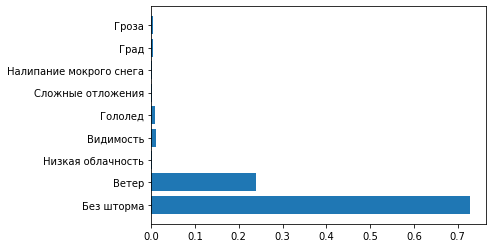

In [3]:
import matplotlib.pyplot as plt
storm = ('Без шторма', 'Ветер', 'Низкая облачность', 'Видимость', 'Гололед', 'Сложные отложения', 'Налипание мокрого снега', 'Град', 'Гроза')
fig, ax = plt.subplots()
ax.barh(storm, np.squeeze(predictions))

In [13]:
predictions

array([[9.1318750e-01, 7.4757315e-02, 7.0336275e-05, 8.5953949e-03,
        5.8539154e-05, 2.8952809e-06, 3.9993134e-05, 3.6103160e-05,
        3.2519891e-03]], dtype=float32)